## Optimizing Airline Revenue Using Dynamic Pricing

### Executive Summary
This project demonstrates a dynamic pricing optimizer for simulated airline flights. Using multiple linear regression to forecast demand, we a applied a continuous price adjustment around existing fares.

- **Mean baseline revenue per flight**: €11,661
  
- **Mean optimized revenue per flight**: €13,344
  
- **Mean revenue uplift**: 14.4%

The results shows that even small, targeted price adjustments can lead to revenue gains. While this is based on synthetic data, the framework could be applied to real-world airline operations for improvements in revenue optimization.

### Introduction

Aviation is an industry with a traditionally rigid pricing structure. Legacy IT systems have limited airlines to a discrete set of price points, called booking classes.

Dynamic pricing enables airlines to adjust fares using a continuous pricing structure, allowing for improved revenue optimization.

This notebook simulates airline demand and forecasts it using a regression model. We then estimate demand elasticity and compute the revenue uplift of a continuous dynamic pricing model compared to a traditional discrete pricing structure.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Generation
We generate synthetic booking data for one year of flights between **London Heathrow (LHR)** and **Charles De Gaule (CDG)**. Each plane has a maximum capacity of 180 seats. Thus we simulate **constrained demand**, where demand cannot exceed seat capacity.

Each flight represents one flight departure, with corresponding fares, competitor prices, and observed booking behavior.

Our example airline, **HL airlines**, operates six daily LHR-CDG flights, with **10 discrete price points** between **100 EUR and 200 EUR**, and demand decreases as price increases to simulate realistic price elasticity.

In [106]:
# Data Generation
np.random.seed(1234)

# Variables:
# - Price
# - Season
# - Competitor price
# - Days to departure
# - Demand

# HL airlines flies 6 daily LHR-CDG, leading to 2190 flights in one year
n = 2190

# HL price ladder: 10 RBDs between 100-200 EUR
booking_fares = np.arange(100, 201, 10)
airline_price = np.random.choice(booking_fares, size = n)

# Competitor airline OA has price points between 0-15 EUR around HL
competitor_price = airline_price + np.random.normal(0, 15, n)

# 1 year of departures = 365 dbds 
days_before_departure = np.random.randint(0, 365, n)

# Three seasons: high, low and, shoulder
seasons = np.random.choice(['high', 'shoulder', 'low'], n)
season_factor = {
    'high': 1.2,
    'shoulder': 1.0,
    'low': 0.8
}
season_multiplier = np.array([season_factor[s] for s in seasons])

# Demand model
# Demand falls with price
base_demand = 6000 / airline_price

# Higher demand further from departure
time_effect = 1 + 0.005 * days_before_departure

# If HL price < OA price, we get more demand
competition_effect = 1 + (competitor_price - airline_price) / 50

# Stochastic demand
demand = base_demand * time_effect * competition_effect * season_multiplier
demand += np.random.normal(0, 10, n)

# Capacity constrain the demand to 180 seats
max_capacity = 180
demand = np.clip(demand, 0, max_capacity)

synthetic_demand = pd.DataFrame({
    'airline_price': airline_price.round(2),
    'season': seasons,
    'competitor_price': competitor_price.round(2),
    'days_before_departure': days_before_departure,
    'demand': demand.round(0)
})

synthetic_demand.head()

synthetic_demand.to_csv('synthetic_demand.csv', index = False)

### Exploratory Data Analysis
We explore the synthetic dataset to assess whether it reflects realistic airline booking behaviours. Focus areas include price-demand relationships, seasonal behaviors, and competition.

Preliminary analysis shows indicates that demand decreases as price increases for **HL airlines**.

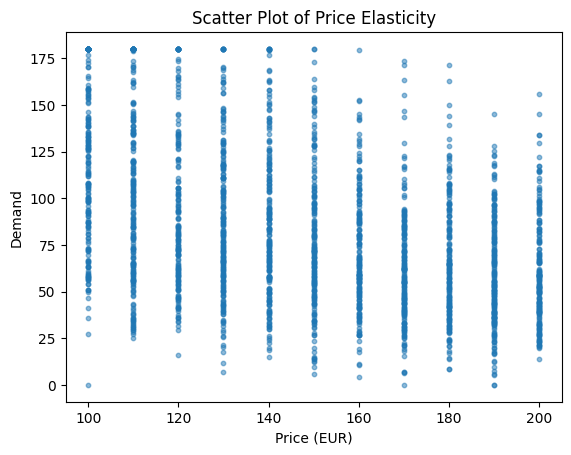

In [107]:
# Price elasticity
# Demand should drop as price increases
plt.scatter(airline_price, demand, alpha = 0.5, s = 10)
plt.title("Scatter Plot of Price Elasticity")
plt.xlabel("Price (EUR)")
plt.ylabel("Demand")
plt.show()

The demand is segmented into **low**, **shoulder** and **high** seasons. The boxplots below should the distribution of demand across these periods. As expected, the **median demand** rises progressively from low to shoulder to high season, reflecting stronger booking activity during peak periods.

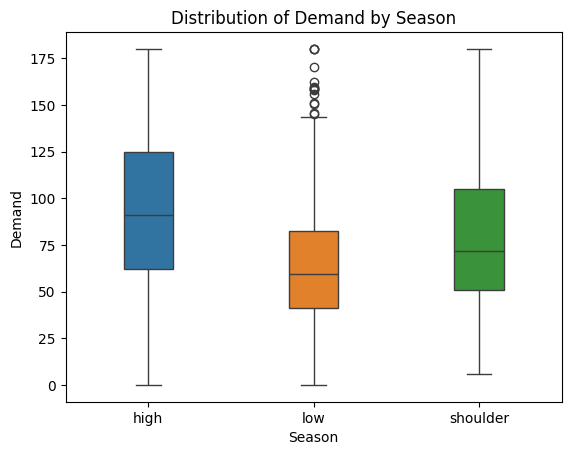

In [108]:
# Seasonality
# Show the median and range of demand per season with boxplots
sns.boxplot(y = demand, 
            x = seasons, 
            hue = seasons, 
            width = 0.3)
plt.title("Distribution of Demand by Season")
plt.ylabel("Demand")
plt.xlabel("Season")
plt.show()

Benchmarking refers to how airlines adjust their fares relative to competitors. We calculate the **price difference** as:

*Competitor price - HL airlines price = price difference*

A negative price difference means **HL Airlines** is cheaper than the competitor. As expected, we observed a roughly linear relationship where **demand increases if HL airlines offer lower fares** than the competition.

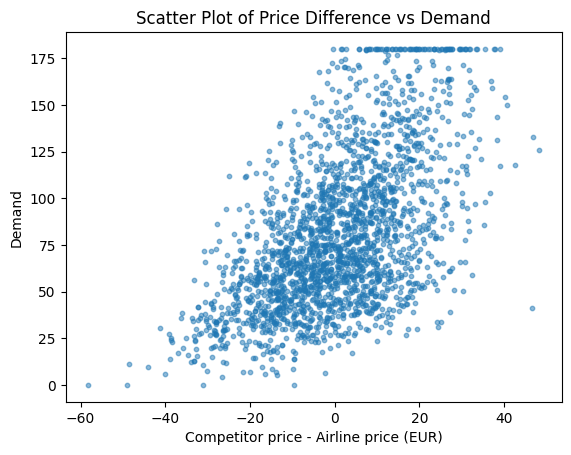

In [6]:
# Benchmarking
# Investigates competitor price relationship to demand
price_diff = competitor_price - airline_price
plt.scatter(price_diff, demand, alpha = 0.5, s = 10)
plt.title("Scatter Plot of Price Difference vs Demand")
plt.xlabel("Competitor price - Airline price (EUR)")
plt.ylabel("Demand")
plt.show()


Days Before Departure (DBD) measure how many days remain until a flight departs. In a real airline environment, **demand typically falls as DBD decreases**, since fewer seats remain available for sale. 
Our synthetic data reflects this relationship, showing lower demand as the flight gets closer to departure.

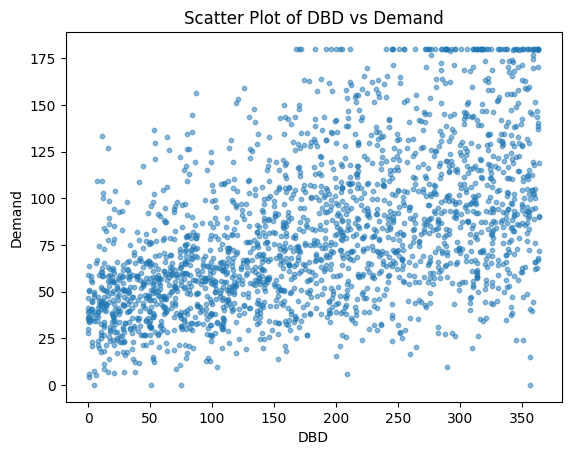

In [7]:
# Demand by DBD
# Investigate the relationship between DBDs and demand
plt.scatter(days_before_departure, demand, alpha = 0.5, s = 10)
plt.title('Scatter Plot of DBD vs Demand')
plt.xlabel('DBD')
plt.ylabel('Demand')
plt.show()

While our synthetic dataset lacks the full complexity of real-world airline data, it successfully capture several relationships observed in practice.

We can therefore proceed with condifence to develop a demand foresting model based on these simulated dynamics.

### Demand Modeling

We trained a multiple linear regression model to predict demand based on:
- HL airline fare

- Competitor fare

- Days before departure

The parameter coefficients show that demand decreases with the price of HL airline tickets. If the competitor increases prices, demand for HL airlines rises. DBD also has a slight positive relationship, indicating that demand is higher further away from departure

The model has reasonable predictive power (R^2 = 0.8, RMSE = 18). 

Although the demand model is simplified due to the synthetic nature of our data, it provides a reasonable foundation for exploring a dynamic pricing strategy.

In [111]:
# Demand Modeling - Regression
# First we fit a multiple linear regression model to predict the demand
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = pd.DataFrame(synthetic_demand, columns = ['airline_price', 'competitor_price', 'days_before_departure'])
y = demand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

# Create model and fit to training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
baseline_demand = model.predict(X_test)
baseline_demand = np.clip(baseline_demand, 0, max_capacity)

# Model parameters
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

coef_df

,Feature,Coefficient
0,airline_price,-2.053945
1,competitor_price,1.528932
2,days_before_departure,0.199605


In [110]:
# Model metrics
# R^2
r2 = r2_score(y_test, baseline_demand)
r2 = round(r2, 4)

# MSE
mse = mean_squared_error(y_test, baseline_demand)
mse = round(mse, 2)

# RMSE
rmse = mse ** 0.5
rmse = round(rmse, 2)


model_metrics = pd.DataFrame({
'Metric': ['R-squared', 'MSE', 'RMSE'],
'Value': [r2, mse, rmse]
})

model_metrics

,Metric,Value
0,R-squared,0.8026
1,MSE,322.2900
2,RMSE,17.9500


### Price Optimization
We simulate a dynamic pricing engine with a continuous price structure. For each flight we explore a bounded price ladder of ±5% around the current booking class price. Price optimization consists of identifying the fare that maximizes expected revenue based on the demand predicted by our linear regression model.

In [10]:
# Price optimization
# Introduce 5% lower and upper dynamic pricing boundaries
bounded_ladder = np.arange(0.95, 1.0501, 0.005)

n_flights = X_test.shape[0]
n_prices = bounded_ladder.shape[0]

# Simulate price x fare combinations across flights
base_prices = X_test['airline_price'].values.reshape(-1, 1)
price_ladder = base_prices * bounded_ladder

X_expanded = np.repeat(X_test.values[:, :, np.newaxis], n_prices, axis = 2)
X_expanded = X_expanded.transpose(0, 2, 1)
X_expanded[:, :, 0] = price_ladder

# (flights x prices) x features
X_reshaped = X_expanded.reshape(-1, X_test.shape[1])
X_reshaped_df = pd.DataFrame(X_reshaped, columns = X_test.columns)

# Predict demand for all flight x price combinations
predicted_demand = model.predict(X_reshaped_df)
predicted_demand = np.clip(predicted_demand, 0, max_capacity)
predicted_demand = predicted_demand.reshape(n_flights, n_prices)

# Revenue = price * predicted demand
revenues = predicted_demand * price_ladder

# Optimize the price per flight and calculate revenue
best_price_idx = np.argmax(revenues, axis = 1)
optimal_prices = price_ladder[np.arange(n_flights), best_price_idx]

# Optimal revenue
model_revenues = revenues[np.arange(n_flights), best_price_idx]

# Baseline revenue
baseline_revenues = X_test['airline_price'].values * model.predict(X_test)

### Results
We applied the dynamic pricing optimizer with ±5% price boundaries around the existing fares on our simulated flights. 
- **Mean baseline revenue per flight**: €11,661
  
- **Mean optimized revenue per flight**: €13,344
  
- **Mean revenue uplift**: 14.4%

Demand shifted slightly as some flights were priced higher, while others were discounted

This demonstrates the positive effect from a dynamic pricing optimizer with a continuous price points on revenue. While the uplift is **overly optimistic** due to the limitations of simulated data, even small percentage improvements can translate to significant revenue gains in real airline operations.

In [11]:
# Results
# Comparing revenue of actual vs optimizer price
results_df = X_test.copy()
results_df['baseline_revenue'] = baseline_revenues
results_df['optimized_price'] = optimal_prices
results_df['model_revenue'] = model_revenues

# Results table
results_table = pd.DataFrame({
    'Metric': ['Mean baseline revenue', 'Mean optimized revenue', 'Mean revenue uplift'],
    'Value': [
        f"{results_df['baseline_revenue'].mean():,.0f} EUR",
        f"{results_df['model_revenue'].mean():,.0f} EUR",
        f"{((results_df['model_revenue'].mean() - results_df['baseline_revenue'].mean()) / results_df['baseline_revenue'].mean() * 100):.1f}%"
    ]
})

results_table


,Metric,Value
0,Mean baseline revenue,"11,661 EUR"
1,Mean optimized revenue,"13,344 EUR"
2,Mean revenue uplift,14.4%


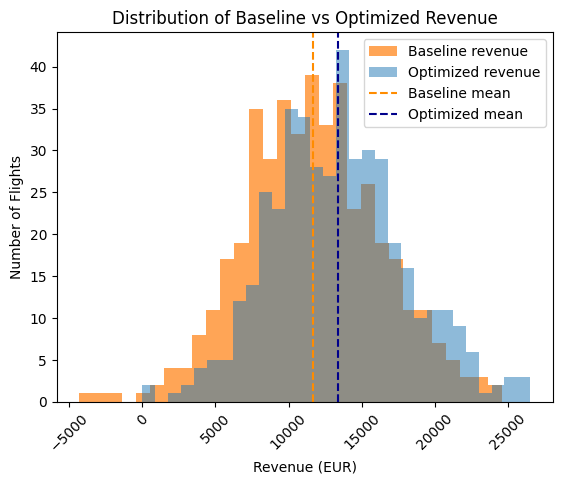

In [ ]:
# Results visualization
plt.hist(results_df['baseline_revenue'],
         bins = 30,
         alpha = 0.7,
         color = 'tab:orange',
         label = 'Baseline revenue')
plt.hist(results_df['model_revenue'],
         bins = 30,
         alpha = 0.5,
         color = 'tab:blue',
         label = 'Optimized revenue')
plt.xlabel('Revenue (EUR)')
plt.ylabel('Number of Flights')
plt.title('Distribution of Baseline vs Optimized Revenue')
plt.axvline(results_df['baseline_revenue'].mean(), 
            color = 'darkorange',
            linestyle = '--',
            label = 'Baseline mean')
plt.axvline(results_df['model_revenue'].mean(), 
            color = 'darkblue',
            linestyle = '--',
            label = 'Optimized mean')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Next Steps
- **Apply the optimizer to real airline data** to evaluate its performance in a real operational environment

- **Test alternative demandforecasting models**, such a XGBoost, and compare their predictive accuracy and resulting revenue optimization against the multiple linear regression model

- **Include more granular data**, such as actual booking classes and ticket-level bookings, to achieve more realistic revenue outcomes